In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets as Datasets
from torchvision import transforms

mnist_train_transforms = transforms.Compose([
    transforms.ToTensor(),
])
mnist_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

training_set = Datasets.MNIST(root='../../autoencoder', download=False, train=True, transform=mnist_train_transforms)
validation_set = Datasets.MNIST(root='../../autoencoder', download=False, train=False, transform=mnist_test_transforms)

/home/ritish/prog/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class EncoderLin(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        return x
    
class DecoderLin(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x
    
class CAE_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EncoderLin()
        self.decoder = DecoderLin()

    def forward(self, x):
        e_out = self.encoder(x)
        d_out = self.decoder(e_out)
        return e_out, d_out

In [4]:
class EncoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class DecoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x.view(-1, 1, 28, 28)
    
class CAE_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EncoderConv()
        self.decoder = DecoderConv()

    def forward(self, x):
        e_out = self.encoder(x)
        d_out = self.decoder(e_out)
        return e_out, d_out

In [122]:
# https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

# Contractive loss function to enforce contraction of representations
def loss_function(e_out, d_out, inp, L=1e-4):
    criterion = nn.MSELoss()
    loss1 = criterion(d_out, inp)

    # Calculate jacobian of encoder output wrt input
    e_out.backward(torch.ones_like(e_out), retain_graph=True)

    # Frobenius norm of jacobian
    loss2 = torch.sqrt(torch.sum(torch.pow(inp.grad, 2)))
    
    # Total loss
    return loss1 + L*loss2

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE_Conv().to(device)

In [124]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)
train_loader = DataLoader(training_set, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(validation_set, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)

In [125]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (imgs, _) in enumerate(tqdm(train_loader)):
        imgs = imgs.to(device)
        
        # Required to calculate jacobian of encoder output wrt input
        imgs.requires_grad = True

        # Forward pass
        e_out, d_out = model(imgs)
        loss = loss_function(e_out, d_out, imgs, L=1e-4)

        # Backpropogate and update weights
        optimizer.zero_grad()
        loss.backward()

        # Zero out gradients of input
        imgs.grad.data.zero_()

        optimizer.step()
        train_loss += loss.item()
    print(f'Train Loss: {train_loss/len(train_loader)}')

100%|██████████| 235/235 [00:01<00:00, 211.96it/s]


Train Loss: 0.30072586530066553


100%|██████████| 235/235 [00:01<00:00, 216.66it/s]


Train Loss: 0.30905027630481313


100%|██████████| 235/235 [00:01<00:00, 223.26it/s]

Train Loss: 0.4293945841332699


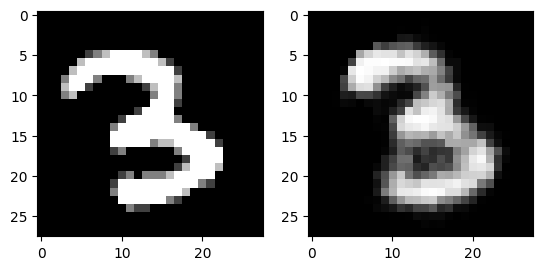

In [130]:
# Testing the model
model.eval()
test_loss = 0
with torch.no_grad():
    img, _ = next(iter(val_loader))
    img = img.to(device)
    _, d_out = model(img)
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img[0].cpu().numpy().squeeze(), cmap='gray')
    ax[1].imshow(d_out[0].cpu().numpy().squeeze(), cmap='gray')